Yolo V5 es uno de los mejores modelos disponibles para la detección de objetos en este momento. Lo mejor de esta red neuronal profunda es que es muy fácil volver a entrenar la red en su propio conjunto de datos personalizado.  Usaremos un dataset que hemos etiquetado nosotros manualmente con la herramienta que nos proporciona roboflow. El formato que se vamos a generar es YoloV5 Pytorch, aunque se pueden elegir otros. La combinación del repositorio que nos proporciona Ultralytics con las herramientas de roboflow, nos permitirán entrenar un modelo para detectar personas. El objetivo final, es crear un contador de personas para controlar el aforo en superficies.

#Pasos a seguir

* Instalar dependencias de YOLO
* Descargar los datos de roboflow
* Configuración de modelo
* Entrenar el modelo
* Evaluar la efectividad del modelo
* Visualizar los datos de entrenamiento etiquetados
* Ejecutar el modelo con los datos de test
* Descargar los pesos obtenidos

##Instalar dependencias de YOLO
Se clona el repositorio de YOLOv5 que nos proporciona Ultralytics, una consultora estadounidense que ha compartido este repositorio para que se puedan entrenar modelos. Además se instalan los paquetes necesarios, que vienen en un txt en el propio repositorio.

In [ ]:
# Clonamos el repositorio de yolov5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 12387, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 12387 (delta 50), reused 43 (delta 20), pack-reused 12292
Receiving objects: 100% (12387/12387), 12.76 MiB | 32.65 MiB/s, done.
Resolving deltas: 100% (8516/8516), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [ ]:
%ls #Vemos que se ha clonado el repositorio y las carpetas que tenemos en él

CONTRIBUTING.md  export.py   models/           setup.cfg       utils/
data/            hubconf.py  README.md         train.py        val.py
detect.py        LICENSE     requirements.txt  tutorial.ipynb


In [ ]:
# instalamos las dependendencias necesarias
!pip install -qr requirements.txt  
import torch

from IPython.display import Image, clear_output  # para tratar imágenes
from utils.downloads import attempt_download  # para descargar los datasets

# Aquí vemos las características de la máquina que nos presta Google
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 1.6 MB 7.0 MB/s 
Setup complete. Using torch 1.12.1+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


## Descargar los datos de roboflow
En este apartado usaremos un dataset que ya está subido y etiquetado en roboflow. Si subimos nosotros un dataset, hay que indicarle el tamaño de las imágenes (416 ó 620 normalmente), porque posteriormente nos hará falta para indicárselo al modelo.

Cuando se genera el dataset en roboflow, no es necesario indicarle que lo haga con Data Augmentation, ya que el modelo de Yolov5 ya realiza esta técnica en su entrenamiento.

In [ ]:
# Instalamos la librería de roboflow y usamos el link para acceder al dataset
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

     |████████████████████████████████| 145 kB 7.6 MB/s 
     |████████████████████████████████| 178 kB 55.6 MB/s 
     |████████████████████████████████| 1.1 MB 69.6 MB/s 
     |████████████████████████████████| 67 kB 4.0 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 138 kB 72.0 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


Descargamos el dataset usando el código que obtenemos en Roboflow, donde le hemos indicado que lo descargue en formato YOLO v5 Pytorch.

In [ ]:
%cd /content/yolov5/ #Para cambiar de directorio

rf = Roboflow(api_key="KCRP0cBFPhv1m5oQyZyU")
project = rf.workspace("tfm-nxikd").project("tfm-ulepf")
dataset = project.version(6).download("yolov5")
#Se descargará en la carpeta TFM-"número de la version"

[Errno 2] No such file or directory: '/content/yolov5/ #Para cambiar de directorio'
/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to TFM-6 in yolov5pytorch:: 100%|██████████| 4262/4262 [00:02<00:00, 1845.25it/s]


In [ ]:
print(dataset.location)

/content/yolov5/TFM-6


Aquí roboflow genera un archivo con extensión yaml que contiene el número de categórias, su nombre y la ruta de las imágenes train y valid.

In [ ]:
%cat {dataset.location}/data.yaml

names:
- People
nc: 1
train: TFM-6/train/images
val: TFM-6/valid/images


##Configuración de modelo
Uno de los usos más comunes de los archivos yaml es la creación de archivos de configuración. Se recomienda utilizar YAML en lugar de JSON para escribir los archivos de configuración porque es un lenguaje más fácil de comprender, aunque ambos pueden usarse de manera indistinta en la mayoría de los casos.  

In [ ]:
# Obtenemos un diccionario del archivo yaml que se ha generado y extraemos el número de clases
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#Esta es la configuración que por defecto se usa para entrenar el modelo
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#Con las siguientes dos celdas, modificamos los parámetros y escribimos los parámetros que queremos cambiar (solo cambia la parte backbone)
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

#Entrenamiento el modelo

Entrenamos ahora el modelo, al cual se le pueden indicar los siguientes argumentos:
- **img:** tamaño de la imágen (hay que tenerlo en cuenta según lo que se le haya indicado en roboflow)
- **batch:** tamaño del batch
- **epochs:** el número de epochs. (NORMALMENTE SON MÁS DE 3000 AUNQUE NOSOTROS NO PODREMOS INDICARLE TANTAS)
- **data:** la ruta al archivo yaml de datos
- **cfg:** la configuración del modelo
- **weights:** la ruta donde se guardarán los pesos 
- **name:** el nombre de los resultados
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
#Para saber el tiempo que tarda
%%time
%cd /content/yolov5
!python train.py --img 620 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/TFM-6/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=620, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 221 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0

#Evaluación de la efectividad del modelo

Tenemos un --% de mean Average Precision (mAP50). El objetivo de un modelo es que nos detecte los objetos exactamente donde se hallan en la imagen y que no detecte objetos donde no los hay, especialmente cuando hay objetos solapados, que es cuando más puede haber lugar a confusión. Mean Average Precision (mAP) es una de las métricas más comununes que se aplican para medir los resultados de los algoritmos de detección de objetos. Para entenderla, primero tenemos que ver algunos conceptos básicos. 

La fórmula está basada en los siguientes conceptos: precision, recall y Intersection over Union. A su vez, precision y recall están basados en los Verdaderos Positivos, Falsos Negativos y Falsos Positivos. Veámos estos conceptos con detalle.

1. Que es VP,FN y FP?

* VP: el modelo ha predicho un objeto correctamente.
* FN: el modelo no ha predicho una objeto que si que se encuentra en la imagen.
* FP: el modelo ha predicho una objeto de forma errónea.

2. Que es precision, recall, IoU y umbral de confianza?

* Precision: representa las predicciones correctas sobre todas las predicciones hechas. Nos indica cuanto nos podemos fiar de las predicciones hechas. 
$\frac{TP}{TP + FP}$

* Recall: representa las predicciones correctas sobre todas las posibles. Nos indica como ha predicho cada vez que debería haberlo hecho.
$\frac{TP}{TP + FN}$

* IoU: Es la intersección entre la caja predicha y la caja real de un objeto, sobre la unión de las dos. Cuanto mayor sea el IoU, las predicciones de modelo serán más precisas en cuanto a la caja que envuelve el objeto detectado. Cuanto menor sea, el modelo considerará como buena una predicción de la cual solo se ha detectado una parte de la imagen.

* Umbral de confianza: es el porcentaje de confianza que le damos al modelo para que considere una predicción como correcta o no. Si el umbral de confianza es bajo, veremos más predicciones pero serán menos precisas, por tanto aumentará el recall pero disminuirá la precision.

Vemos que hay una compensación entre el umbral de confianza y el IoU y las métricas recall y precision.

3. Que es la curva precision-recall?

La curva precision-recall se obtiene representando la precision (eje Y) y el recall (eje X) en función del umbral de confianza. Es una manera de visualizar como se comporta el modelo a medida que desciende el umbral de confianza. Así pues, la curva precision-recall tiene pendiente negativa. Esto sucede porque si aumenta el recall, baja la precision, clasifica muy bien las que son correctas pero tiene muchos falsos positivos, es decir, clasifica muchos objetos en la clase que no son. Cuando tenemos un bajo recall, se tiene una alta precision, el modelo es muy bueno cuando hace una predicción pero se deja muchos objetos por clasisficar. De esta manera, surgen tres métricas que combinan precision y recall y maximizan el efecto de ambas.

4. Que métricas surgen de esta curva? F1, PR AUC y AP

* F1: Es el valor del umbral de confianza óptimo para ambas métricas, si F1 es alto, significa que ambas métricas son altas. $F1 = \frac{2 \times (Precision \times Recall)}{Precision + Recall}$

* PR AUC: Es el área bajo la curva que sintetiza los diferentes valores de la curva PR para los diferentes umbrales de confianza.

* AP: Average Percentage es la media ponderada de todos los valores de precision para un número finito de valores de umbrales de confianza.

5. Que es mAP50?
mAP es la media del AP de cada clase, que en este caso solo tenemos una. mAP50 significa que se le ha dado un valor mínimo del 0.5 al parámetro IoU para considerar una predicción como correcta.


In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# Esto es simplemente otra forma de ver los gráficos. 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

In [ ]:
%ls runs/train/yolov5s_results/

#Visualización de los datos de entrenamiento etiquetados

Esto simplemente es para ver un batch de las imágenes de entramiento, contiene 16 imágenes, que son las que le hemos indicado.

GROUND TRUTH TRAINING DATA:


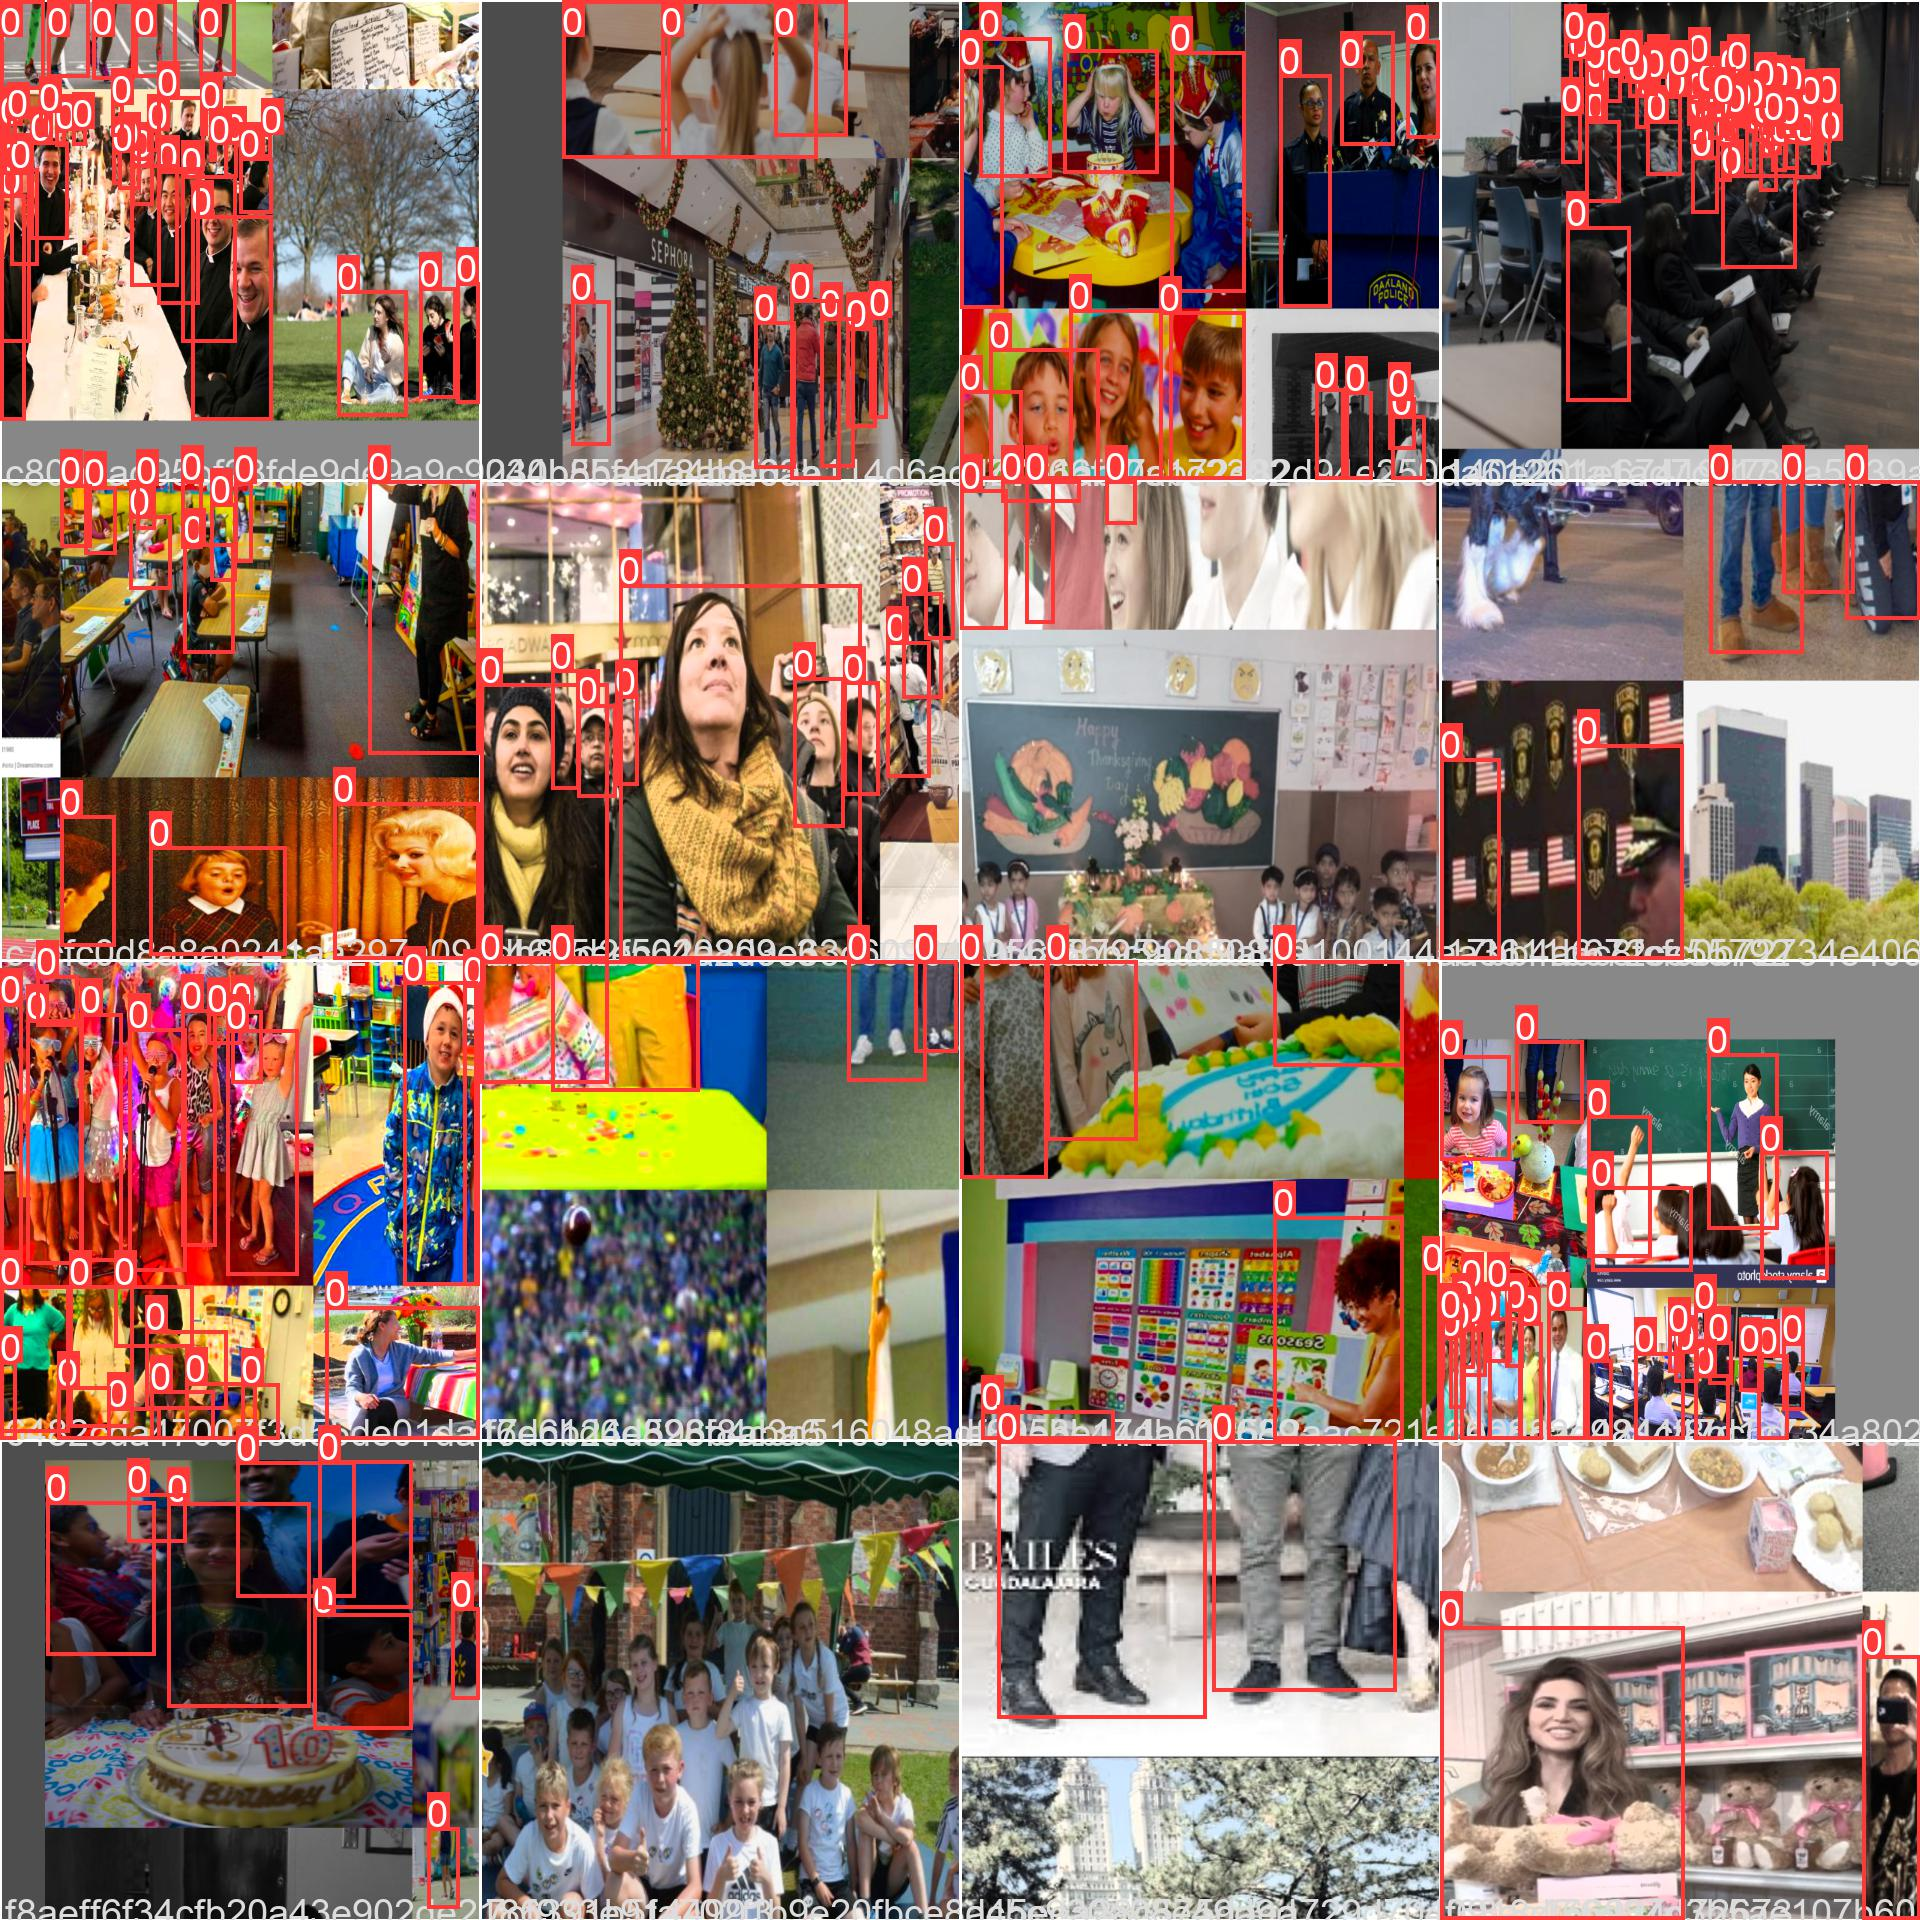

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

#Ejecución del modelo con los datos de test

Comprobación en las imágenes test.

In [ ]:
# Los pesos entrenados se guardan por defecto en nuestra carpeta de pesos
%cd /content/yolov5/
%ls runs/train/yolov5s_results/weights/

/content/yolov5
best.engine  best.onnx  best.pt  last.pt


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
#La cantidad de imágenes de test debe coincidir con la que indica roboflow (322) en la versión 6 del dataset
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 620 --conf 0.4 --source test2.mp4


/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=test2.mp4, data=data/coco128.yaml, imgsz=[283, 283], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs
video 1/1 (1/401) /content/yolov5/test2.mp4: 192x288 Done. (0.013s)
video 1/1 (2/401) /content/yolov5/test2.mp4: 192x288 Done. (0.009s)
video 1/1 (3/401) /content/yolov5/test2.mp4: 192x288 Done. (0.010s)
video 1/1 (4/401) /content/yolov5/test2.mp4: 192x288 Done. (0.009s)
video 1/1 (5/401) /content/yolov5/test2.mp4: 192x288 Done. (0.

Podemos ver los resultados visualmente.

In [ ]:
#Veamos el resultado visualmente

import glob
from IPython.display import Image, display, Video
import cv2 
import time

cap = cv2.VideoCapture('tree.mp4')

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.mp4'): #assuming mp4
    display(Video(filename=imageName))
    print("\n")

TypeError: ignored

Para mostrar el video que se ha generado ya etiquetado.

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('prueba.mp4','rb').read()
#mp4 = open('runs/detect/exp6/test2.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source test.jpg

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=test.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs
image 1/1 /content/yolov5/test.jpg: 256x416 Done. (0.013s)
Speed: 0.3ms pre-process, 12.7ms inference, 0.5ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp3


#Aplicar el modelo en local

1. Descargamos el repositorio en local, porque hacen falta funciones que están definidas en ciertas carpetas del repositorio.

2. En la carpeta principal, donde se encuentra el archivo detect.py, deben estar los archivos best.pt (los pesos) y el video o imagen sobre el que se vaya a usar el modelo.

3. Instalamos requirements.txt:

!pip install -qr requirements.txt

4. Ejecutamos el archivo detect.py sobre el video y usando los argumentos que le indiquemos:

!python detect.py --weights best.pt --img 620 --conf 0.4 --source video.mp4

Lógicamente, los archivos pueden estar en otra ruta pero habría que indicarsela.

5. Los resultados aparecen la subcarpeta runs/detect/exp, que si ya existe se irá incrementando el número de esta subcarpeta exp2,exp3... 

#Descarga de los pesos obtenidos

In [ ]:
!pip install -U nvidia-tensorrt --index-url https://pypi.ngc.nvidia.com  # install
clear_output()

In [ ]:
!python export.py --weights 'runs_penguins/fine-tuning/weights/best.pt' --include engine onnx --data 'data/penguins_data.yaml' --device 0 --imgsz 640 640
clear_output()